In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy_sz import Class
import os
import time




# the parameters needed for cosmology:
# use the last column of Planck 2018 (https://arxiv.org/pdf/1807.06209.pdf) Table 2
# TT,TE,EE+lowE+lensing+BAO
cosmo_params = {
'omega_b': 0.02242,
'omega_cdm':  0.11933,
'H0': 67.66, # use H0 because this is what is used by the emulators.
'tau_reio': 0.0561,
'ln10^{10}A_s': 3.047,
'n_s': 0.9665,

'k_pivot': 0.05,
#'N_ncdm': 1,
#'N_ur': 2.0328,
#'m_ncdm': 0.06    

}

# a simple conversion from cl's to dl's
def l_to_dl(lp):
    return lp*(lp+1.)/2./np.pi



2024-04-03 10:46:34.049325: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-03 10:46:34.049345: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-03 10:46:34.049350: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-03 10:46:34.049385: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-03 10:46:34.049407: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
label_size = 15
title_size = 20
legend_size = 13
handle_length = 1.5


In [3]:
working_folder = '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/class_sz_auxiliary_files/'      # we will save some intermediate 
                                                  # files in this folder so that the C wrapper of CLASS will be able to 
                                                  # open them

### Define some galaxy survey params: redshift range, number of bins, etc

In [4]:
z_min = 1e-5
z_max = 6

N_bin = 8    # the number of redshift bins you want to compute

z_bin_boundaries = np.linspace(z_min,z_max,N_bin+1)    # define bins linearly in z-space


n_z = 1000

z = np.geomspace(0.01,z_max,n_z)


### Define the dndz of your galaxy survey 

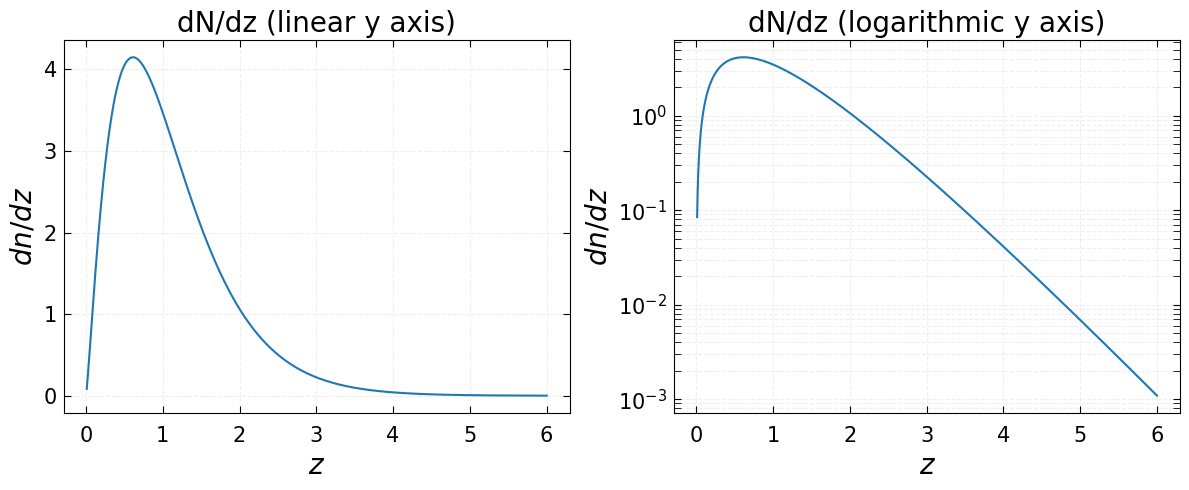

In [5]:
def dndz(z,normalize=False):
    
    ns = 26
    alpha = 1.24
    beta = 1.01
    zmed = 0.5
    dndz =  ns * z**(alpha)*np.exp(-(z/zmed)**beta)
    
    if normalize:
        normalization = np.trapz(dndz,z)
        dndz /= normalization
    
    return dndz


fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))

for ax in [ax1,ax2]:
    ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
    ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
    plt.setp(ax.get_xticklabels(), fontsize=label_size)
    ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')

    ax.plot(z,dndz(z))
    
    ax.set_xlabel(r"$z$",size=title_size)
    ax.set_ylabel(r"$dn/dz$",size=title_size)
    
ax1.set_title("dN/dz (linear y axis)",size=title_size)

ax2.set_title("dN/dz (logarithmic y axis)",size=title_size)


ax2.set_yscale('log')

plt.tight_layout()

plt.show()

### Define some Gaussian redshift bins

Because of how Class_sz works, we need to save the dN/dz of the redshift bins as .txt files which will be read in by the Class object later

In [6]:
def gaussian(z,zbar,sigma):
    return 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-(z-zbar)**2/sigma**2)

for zbin in range(N_bin):
    zbar = (z_bin_boundaries[zbin]+z_bin_boundaries[zbin+1])/2
    sigma =  (z_bin_boundaries[zbin]-z_bin_boundaries[zbin+1])/2
    dndz_bin = dndz(z)*gaussian(z,zbar,sigma)
    norm=np.trapz(dndz_bin,z)
    dndz_bin/=norm
    
    
    np.savetxt(working_folder+'LSST_bin'+str(zbin)+'.txt',
               np.concatenate((z[:,None],dndz_bin[:,None]),axis=1))   
    


Now let's read in the files that we just saved, and plot them:

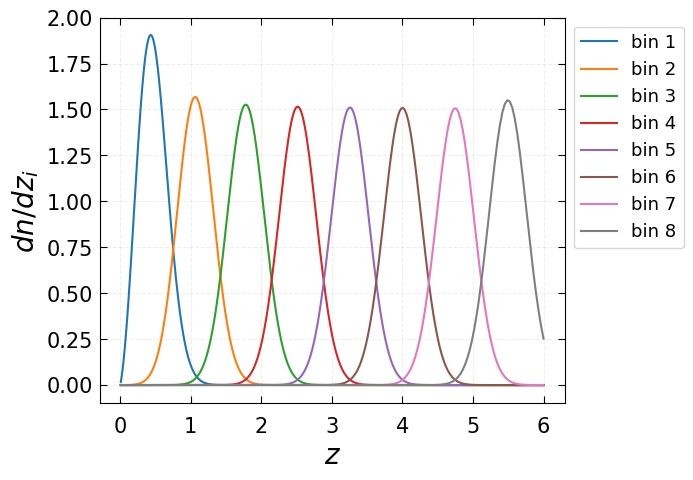

In [7]:

fig, (ax) = plt.subplots(1,1,figsize=(6,5))


ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')


for zbin in range(N_bin):
    
    
    z,dndz_bin = np.loadtxt(working_folder+'LSST_bin'+str(zbin)+'.txt',unpack=True)
               
    ax.plot(z,dndz_bin/1,label='bin '+str(zbin+1))

ax.set_ylabel(r"$dn/dz_i$",size=title_size)
ax.set_xlabel(r"$z$",size=title_size)

ax.legend(fontsize=legend_size,bbox_to_anchor=(1,1))

plt.show()


It will be useful to define a dictionary holding the effective biases of the galaxy samples


In [8]:
def bias(z):
    return (1+z)

gal_bin_effective_biases = {}
for zbin in range(N_bin):
    zbar = (z_bin_boundaries[zbin]+z_bin_boundaries[zbin+1])/2
    gal_bin_effective_biases['bin_'+str(zbin)] = bias(zbar)

## Now compute their C_ells by defining a CLASS() object with class_sz:

In [27]:

ell_max = 500.0
ell_min = 2.0     # In principle we can calculate low ells but note that everything is in the Limber
                # approximation and so will be inaccurate at low ell.

output_specs = {
    'output':'galn_galn_hf,galn_lens_hf',
    'non_linear': 'halofit',
    "ell_max":ell_max,
    "ell_min":ell_min,
    "dlogell":0.1,
}


We may want to compute the C_ells between all bins, or a subsample. Here we specify the bins we want to include

In [28]:

samples_to_compute = range(N_bin)

galaxy_samples =  ','.join([str(x) for x in samples_to_compute])
galaxy_samples   # you can ask for any subset, for example with galaxy_samples =  '0,2,3,7'


'0,1,2,3,4,5,6,7'

In [29]:

gal_survey_specs = {
    'z_min' : z_min,
    'z_max' : z_max,
    
    'galaxy_samples_list_num': len(samples_to_compute),      # the total number of bins you want - needs to match the number
                                                             # of labels in galaxy_samples_list    
    'galaxy_samples_list' :galaxy_samples,                   # the id string of each sample
    'full_path_and_prefix_to_dndz_ngal':working_folder+'LSST_bin', # the folder where we saved the dndz's , with the suffixes
                                                                   # defined in galaxy_samples_list

}
for binind,zbin in enumerate(samples_to_compute[:]):
    '''
    effective_galaxy_bias_ngal_0 corresponds to the first
    label in galaxy_samples_list. Note that the suffix 
    to effective_galaxy_bias_ngal_xx is NOT the label
    but just {0,...,Nbin-1} with the order corresponding
    to the order of the labels in galaxy_samples_list
    '''
    gal_survey_specs['effective_galaxy_bias_ngal_'+str(binind)] = gal_bin_effective_biases['bin_'+str(zbin)]
                                                                
gal_survey_specs

{'z_min': 1e-05,
 'z_max': 6,
 'galaxy_samples_list_num': 8,
 'galaxy_samples_list': '0,1,2,3,4,5,6,7',
 'full_path_and_prefix_to_dndz_ngal': '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/class_sz_auxiliary_files/LSST_bin',
 'effective_galaxy_bias_ngal_0': 1.3750093749999999,
 'effective_galaxy_bias_ngal_1': 2.125008125,
 'effective_galaxy_bias_ngal_2': 2.8750068750000004,
 'effective_galaxy_bias_ngal_3': 3.625005625,
 'effective_galaxy_bias_ngal_4': 4.3750043750000005,
 'effective_galaxy_bias_ngal_5': 5.125003125,
 'effective_galaxy_bias_ngal_6': 5.875001875000001,
 'effective_galaxy_bias_ngal_7': 6.625000625}

### Now we compute the C_ells!

In [30]:
fnls = [0,-10,10]    # the f_nls to compute at

#### initialize the calculation

In [31]:
%%time
M = Class()
M.set(cosmo_params)
M.set(output_specs)
M.set(gal_survey_specs)
M.set(cosmo_params)
M.set(output_specs)
M.set(gal_survey_specs)


M.set({'use scale dependent bias (from non Gaussianity)': 1})  # this option allows you to change the value of f_NL
M.set({'output':'galn_galn_hf,galn_lens_hf'})
# M.set({'fNL' : fnl})
M.compute()

CPU times: user 34 s, sys: 42.9 ms, total: 34.1 s
Wall time: 3.8 s


In [32]:

%%time

# M = Class()
# M.set(cosmo_params)
# M.set(output_specs)
# M.set(gal_survey_specs)


D_ell_gg = {}
D_ell_gk = {}

for fnl in fnls[:]:
    
    # M.set(cosmo_params)
    # M.set(output_specs)
    # M.set(gal_survey_specs)
    
    
    M.set({'use scale dependent bias (from non Gaussianity)': 1})  # this option allows you to change the value of f_NL
    M.set({'output':'galn_galn_hf,galn_lens_hf'})
    # M.set({'fNL' : fnl})

    M.compute_class_sz({'fNL' : fnl})

    D_ell_gg['fnl='+str(fnl)] =  M.cl_galn_galn()  # a dict that contains dicts of D_ell_{gg} (auto and cross)
    D_ell_gk['fnl='+str(fnl)] = M.cl_galn_lens()   # a dict that contains dicts of D_ell_{gk}

CPU times: user 7.04 s, sys: 10.5 ms, total: 7.05 s
Wall time: 742 ms


In [33]:
D_ell_gg['fnl=0'].keys()

dict_keys(['0x0', '1x0', '1x1', '2x0', '2x1', '2x2', '3x0', '3x1', '3x2', '3x3', '4x0', '4x1', '4x2', '4x3', '4x4', '5x0', '5x1', '5x2', '5x3', '5x4', '5x5', '6x0', '6x1', '6x2', '6x3', '6x4', '6x5', '6x6', '7x0', '7x1', '7x2', '7x3', '7x4', '7x5', '7x6', '7x7'])

In [34]:
D_ell_gg['fnl=0']['0x0'].keys()   # Each dict entry is a dict of C_ells that contains the ells and the halofit 
                         # computation of the C_ells (with key 'hf'). As we asked only for halofit computation
                         # the 1h and 2h dict entries will be lists of zeros.
                         # Note that everything is saved as D_ell, and so will need to be divided by l(l+1)/(2pi) to get c_ell!

dict_keys(['ell', '1h', '2h', 'hf'])

In [35]:
D_ell_gk['fnl=0'].keys()

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7'])

In [36]:
D_ell_gk['fnl=0']['0'].keys()    # the same as for D_ell_gg['0x0'].keys() but for gk

dict_keys(['ell', '1h', '2h', 'hf'])

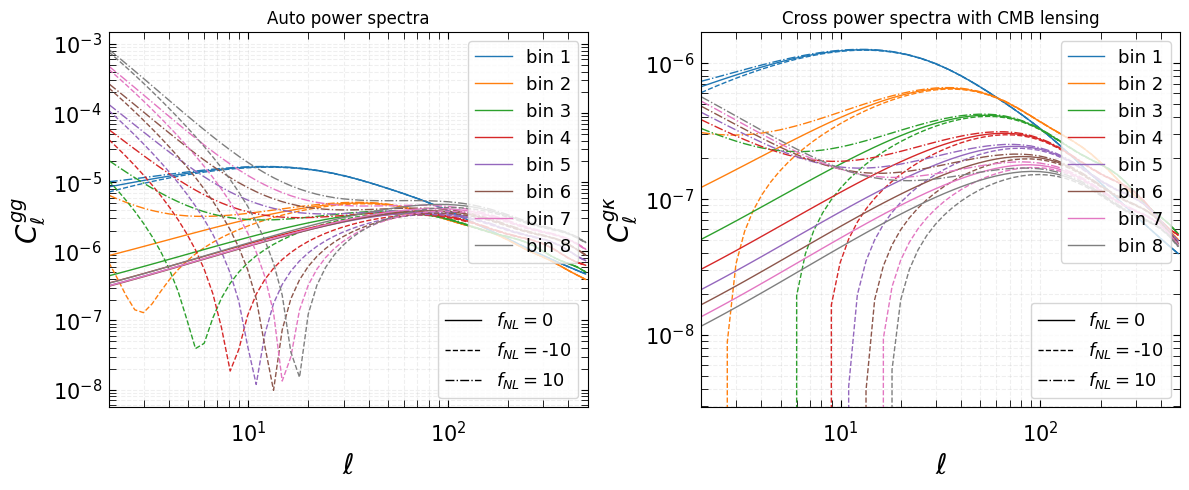

In [47]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))


for ax in [ax1,ax2]:
    ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
    ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
    plt.setp(ax.get_xticklabels(), fontsize=label_size)
    ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')
    
ax = ax1


linestyles = ['-','--','-.']


colors={}

for zbin in samples_to_compute:
        for fnlind,fnl in enumerate(fnls):
            Dl_gg = np.array(D_ell_gg['fnl='+str(fnl)][str(zbin)+'x'+str(zbin)]['hf'])
            l = np.array(D_ell_gg['fnl='+str(fnl)][str(zbin)+'x'+str(zbin)]['ell'])
            if fnlind==0:
                l1,=ax.plot(l,1/l_to_dl(l)*Dl_gg,
                            lw=1,
                            ls=linestyles[fnlind],
                            label='bin ' + str(zbin+1))
                        
            else:
                ax.plot(l,1/l_to_dl(l)*Dl_gg,lw=1,ls=linestyles[fnlind],
                        color=l1.get_color())



ax = ax2

for zbin in samples_to_compute:
    for fnlind,fnl in enumerate(fnls):

        Dl_gk = np.array(D_ell_gk['fnl='+str(fnl)][str(zbin)]['hf'])
        l = np.array(D_ell_gk['fnl='+str(fnl)][str(zbin)]['ell'])
        if fnlind==0:

            l1,=ax.plot(l,1/l_to_dl(l)*Dl_gk,lw=1,label='bin ' + str(zbin+1),ls=linestyles[fnlind])

        else:
            ax.plot(l,1/l_to_dl(l)*Dl_gk,lw=1,ls=linestyles[fnlind],color=l1.get_color())


ax1.set_ylabel(r"$C_\ell^{gg}$",size=title_size)
ax2.set_ylabel(r"$C_\ell^{g\kappa}$",size=title_size)

for ax in [ax1,ax2]:
    ax.set_xlabel(r"$\ell$",size=title_size)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(2,500)
    leg1 = ax.legend(fontsize=legend_size,loc='upper right')
    fnllines=[]
    for fnlind,fnl in enumerate(fnls):
        l1,=ax.plot([500,500],[1e-6,1e-6],color='black',ls=linestyles[fnlind],lw=1)
        fnllines.append(l1)
    leg2 = ax.legend(fnllines,[r'$f_{NL} = $'+str(fnl)for fnl in fnls],loc='lower right',fontsize=legend_size)
    ax.add_artist(leg1)
   
ax1.set_title('Auto power spectra')
ax2.set_title('Cross power spectra with CMB lensing')

plt.tight_layout()
plt.savefig('figures/gg_gk_halofit_cells.pdf')
plt.show()